In [30]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
import copy
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED


# Get Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=464). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=671). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1821). ']
RED 	 464
GRN 	 671
BLU 	 1821


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 464
	 z 	 464
GRN	 ID 	 671
	 z 	 671
BLU	 ID 	 1821
	 z 	 1821


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prep SEDs

In [7]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [8]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 464
	 z 	 464
	 Rest Wavelength 	 464
	 Energy Density 	 464
	 Energy Density Normalized at 1um 	 464
	 Luminosity at 1um 	 464
GRN	 ID 	 671
	 z 	 671
	 Rest Wavelength 	 671
	 Energy Density 	 671
	 Energy Density Normalized at 1um 	 671
	 Luminosity at 1um 	 671
BLU	 ID 	 1821
	 z 	 1821
	 Rest Wavelength 	 1821
	 Energy Density 	 1821
	 Energy Density Normalized at 1um 	 1821
	 Luminosity at 1um 	 1821


In [9]:
def GetMaskOfRedshiftsInRange(z,minZ,maxZ):
    return( (z > minZ) & (z <= maxZ) )

def SplitAGNByZ(agnInfo) : 
    # initialize dict with redshift ranges 
    zRanges = [ (0,1),(1,1.5),(1.5,2),(2,3),(3,99) ]
    agnInfo_byZ = {
        '$0 < z \leq 1$'   : {},
        '$1 < z \leq 1.5$' : {},
        '$1.5 < z \leq 2$' : {},
        '$2 < z \leq 3$'   : {},
        '$3 < z \leq 6$'   : {}
    }
    # for each redshift range...
    i=0
    for zrange, agnAtZ in agnInfo_byZ.items() :
        # ... and each red/grn/blu...
        for color, dataDict in agnInfo.items() : 
            agnAtZ[color] = {}
            zmask = GetMaskOfRedshiftsInRange(dataDict['z'],zRanges[i][0],zRanges[i][1])
            # ... and each measurement ...
            for key,data in dataDict.items() : 
                # ... add only agn in this redshift range
                agnAtZ[color][key] = data[zmask]
        # increment to next redshift range 
        i+=1
    return(agnInfo_byZ)

agnInfo_byZ = SplitAGNByZ(agnInfo)

In [10]:
# AGN ID#1003852 (position 449) as a bad Energy Density data point at index 7 
agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density Normalized at 1um'] [449] [7] = float('nan')
agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density']                   [449] [7] = float('nan')

# SED shapes

In [11]:
print(agnInfo_byZ.keys())
print(agnInfo_byZ['$0 < z \\leq 1$'].keys())
print(agnInfo_byZ['$0 < z \\leq 1$']['RED'].keys())

dict_keys(['$0 < z \\leq 1$', '$1 < z \\leq 1.5$', '$1.5 < z \\leq 2$', '$2 < z \\leq 3$', '$3 < z \\leq 6$'])
dict_keys(['RED', 'GRN', 'BLU'])
dict_keys(['ID', 'z', 'Rest Wavelength', 'Energy Density', 'Energy Density Normalized at 1um', 'Luminosity at 1um'])


In [12]:
# get relevant data
panelData = {
    'RED' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['RED']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('r')

    },
    'GRN' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['GRN']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('g')
    },
    'BLU' : {
        'x'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Rest Wavelength'],
        'y'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Energy Density Normalized at 1um'],
        'z'     : agnInfo_byZ['$0 < z \\leq 1$']['BLU']['Luminosity at 1um'],
        'cmap'  : SED.GetCmap('b')
    }
}

In [13]:
# interpolate
for colorKey, data in panelData.items() :
    f_all = []
    for x,y in zip(data['x'] * 1E-4, data['y']) : 
        f_all.append(SED.Interpolate_log(x,y))
    data['f(x)'] = f_all

In [14]:
# returns the interpolaterd slope between xi and xf for each function in f_arr
def GetSlopes(f_arr,xi,xf) : 
    # initialize array 
    m  = np.zeros(np.shape(f_arr))
    # calculate slope for each function 
    for i,f in enumerate(f_arr) : 
        yi = SED.Flog_X(f,xi)
        yf = SED.Flog_X(f,xf)
        m[i] = (np.log10(yf) - np.log10(yi)) / (np.log10(xf) - np.log10(xi))
    # return slope 
    return m

In [15]:
# get slope and boundary points 
for colorKey, data in panelData.items() : 
    data['Slopes'] = { 
        'UV'   : GetSlopes( data['f(x)'], 0.15, 1.00),
        'MIR1' : GetSlopes( data['f(x)'], 1.00, 6.00),
        'MIR2' : GetSlopes( data['f(x)'], 6.00, 10.0)
    }

In [16]:
def OrList(x,y) : 
    return([x[i] and y[i] for i in range(len(x))])


In [17]:
# returns array containing the 5 panel slope T/F masks 
def SlopePanelMasks(uv_m,mir1_m,mir2_m) : 
    # create bin masks using slopes (m)
    b1 = np.array( (uv_m < -0.3)                  & (mir1_m > -0.4) )
    b2 = np.array( (uv_m > -0.3) & (uv_m < 0.2)   & (mir1_m > -0.4) )
    b3 = np.array( (uv_m >  0.2)                  & (mir1_m > -0.4) )
    b4 = np.array( (uv_m >  0.2)                  & (mir1_m < -0.4) & (mir2_m > 0.0) )
    b5 = np.array( (uv_m >  0.2)                  & (mir1_m < -0.4) & (mir2_m < 0.0) )
    bX = ~(b1 | b2 | b3 | b4 | b5)
    # put masks in list
    panelMasks = np.array([b1,b2,b3,b4,b5,bX])
    # return masks
    return panelMasks

In [18]:
# applied panel mask to x and y, then returns the result 
def PanelData(x,y,z,panelMasks) :
    # initialize lists 
    x_panel = []
    y_panel = [] 
    z_panel = []
    # bin 
    for mask in panelMasks :
        x_panel.append(x[mask])
        y_panel.append(y[mask])
        z_panel.append(z[mask])
    # return x and y panels
    return x_panel, y_panel, z_panel

In [19]:
# get panels
for colorKey, data in panelData.items() : 
    mask = SlopePanelMasks(data['Slopes']['UV'],data['Slopes']['MIR1'],data['Slopes']['MIR2'])
    data['xp'], data['yp'], data['zp'] = PanelData(data['x'], data['y'], data['z'], mask)

In [20]:
# adds #% to top left of ax
def addtext_percent_ax(ax, p, fontsize=adp.SML) :
    ax.text(    0.05,                           # x
                0.90,                           # y 
                str(p)+"%",                     # string
                transform=ax.transAxes,         # use axis coordinants
                horizontalalignment='left',     # alignment 
                fontsize=fontsize               # font size
        )

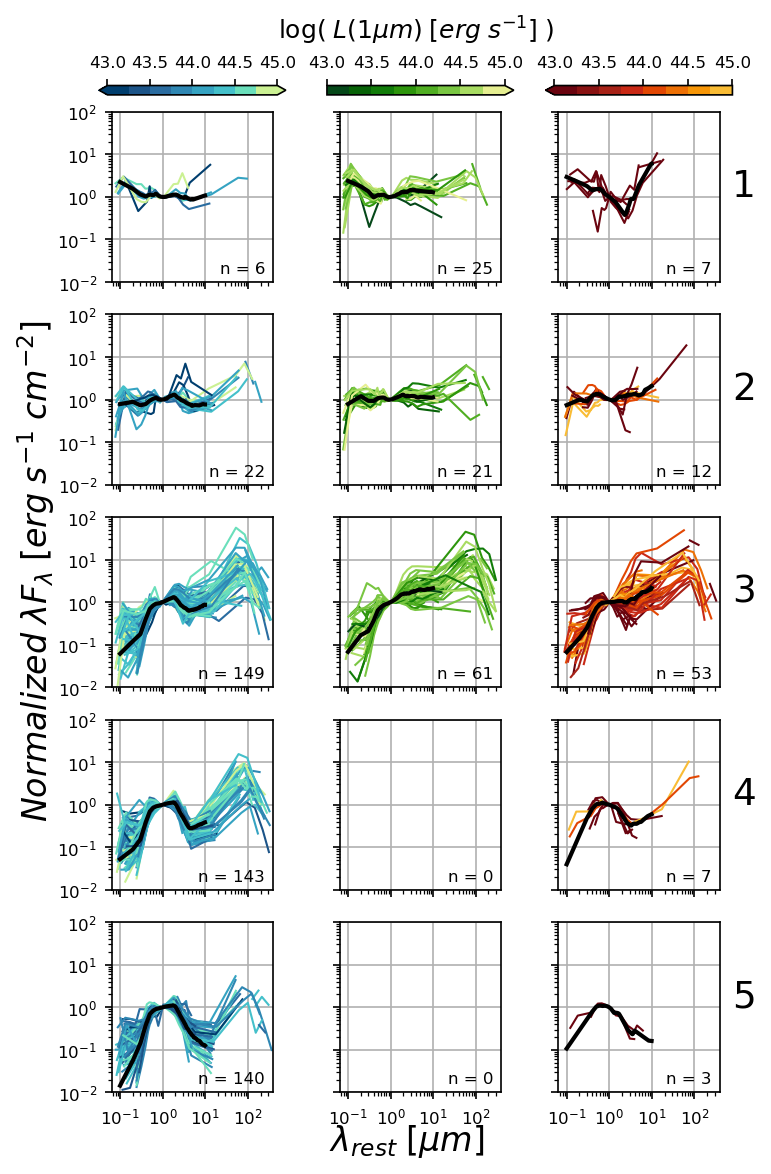

Number of AGN:	 {'RED': 89, 'GRN': 108, 'BLU': 468}
Number of AGN plotted:	 {'RED': 82, 'GRN': 107, 'BLU': 460}
RED missed:  7 (7.9%)
GRN missed:  1 (0.9%)
BLU missed:  8 (1.7%)


In [32]:
def PlotMosaic(
    panelData,
    cbarRange, # tuple range of colorbar (min, max)
    n_rows=5,  # subplot rows
    save='',
    xmin=10**-1.2,      # plot range 
    xmax=10**2.6,       #   "    "
    ymin=10**-2,      #   "    "
    ymax=10**2,       #   "    "
    showPercent = False
):
    # subplot format
    mosaic = []
    for i in range(n_rows) : 
        mosaic.append(['BLU'+str(i+1), 'GRN'+str(i+1), 'RED'+str(i+1)])
    
    # build figure 
    adp.SetStyle()
    fig = plt.figure(figsize=(4.75,7.5), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(
        mosaic, 
        sharex=True, 
        sharey=True
    )

    n = {}
    n_plot = {}
    extend = {}
    for colorKey in panelData.keys() : 
        # number of sources of a color 
        n[colorKey] = len(panelData[colorKey]['x'])
        n_plot[colorKey] = 0
        # colorbar extension 
        extend[colorKey] = 'neither'

    # for each row in plot 
    for i in range(n_rows) : 
        for colorKey in panelData.keys() : 
            # skip if zero 
            if( len(panelData[colorKey]['xp'][i]) == 0 ) :
                # plot setings 
                SED.PlotSED_Settings_ax(
                    ax=ax_dict[colorKey+str(i+1)],    
                    n=0, xLabel=False,yLabel=False,
                    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                )
                if(showPercent) : addtext_percent_ax(ax_dict[colorKey+str(i+1)],0.0)
                adp.AddText_n_ax(ax_dict[colorKey+str(i+1)],0)
            else :
                # get percent 
                n_this = np.shape(panelData[colorKey]['xp'][i])[0]
                n_plot[colorKey] += n_this
                p = round( ( n_this / n[colorKey] )* 100, 1) 
                if(showPercent) : addtext_percent_ax(ax_dict[colorKey+str(i+1)],p)
                # colormap 
                zi = panelData[colorKey]['zp'][i]
                cbarMin=cbarRange[0]
                cbarMax=cbarRange[1]
                z_forMap = SED.PrepareCmapValues(zi, 10**cbarMin, 10**cbarMax) [1]
                # plot 
                SED.PlotSED_ax( 
                    ax=ax_dict[colorKey+str(i+1)], 
                    x=panelData[colorKey]['xp'][i], 
                    y=panelData[colorKey]['yp'][i], 
                    z=z_forMap, 
                    cmap=panelData[colorKey]['cmap'],
                    xLabel=False, yLabel=False,
                    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
                )
                # check cbar bounds
                smaller = np.nanmin(panelData[colorKey]['z']) < 10**cbarRange[0]
                bigger  = np.nanmax(panelData[colorKey]['z']) > 10**cbarRange[1]
                if(smaller and bigger) :    extend[colorKey] = 'both'
                elif(smaller) :             extend[colorKey] = 'min'
                elif(bigger) :              extend[colorKey] = 'max'
                
                # trying to force axis to show up
                ax = ax_dict[colorKey+str(i+1)]            
                locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
                ax.xaxis.set_major_locator(locmaj)
                locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
                ax.xaxis.set_minor_locator(locmin)
                ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

        # panel label (1,2,3,4,5 on right side)
        ax = ax_dict["RED"+str(i+1)]
        ax.text(    1.15,                          # x
                    0.50,                          # y 
                    str(i+1),                      # string
                    transform=ax.transAxes,        # use axis coordinants
                    horizontalalignment='center',  # alignment 
                    size=18
            )

    for colorKey in panelData.keys() : 
        # get label
        if(colorKey=='GRN') : 
            clabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$'
        else :
            clabel=''
        # add colorbars 
        SED.PlotColorbar_ax(
            ax=ax_dict[colorKey+"1"], 
            cmap=panelData[colorKey]['cmap'], 
            min=cbarRange[0], max=cbarRange[1], 
            location='top', 
            extend=extend[colorKey],
            n_ticks=5, 
            label=clabel)

    adp.ByZ_FinishPlot(
        fig=fig,
        xaxis='$\lambda_{rest} \; [\mu m]$',
        yaxis='$Normalized \; \lambda F_{\lambda} \; [erg \; s^{-1} \; cm^{-2}]$',
        save=save,
        xpos=(0.5,-0.015),
        ypos=(-0.05, 0.5),
        fontsize=adp.BIG
    )

    print('Number of AGN:\t',n)
    print('Number of AGN plotted:\t',n_plot)
    for key in n.keys() : 
        diff = n[key] - n_plot[key]
        p = round( (diff / n[key])*100, 1)
        print(key, 'missed: ', diff, '('+str(p)+'%)')


PlotMosaic(
    panelData,
    cbarRange=(43,45),
    save=adp.path_fig+'\\v2_SED_15panel_z01.png'
)

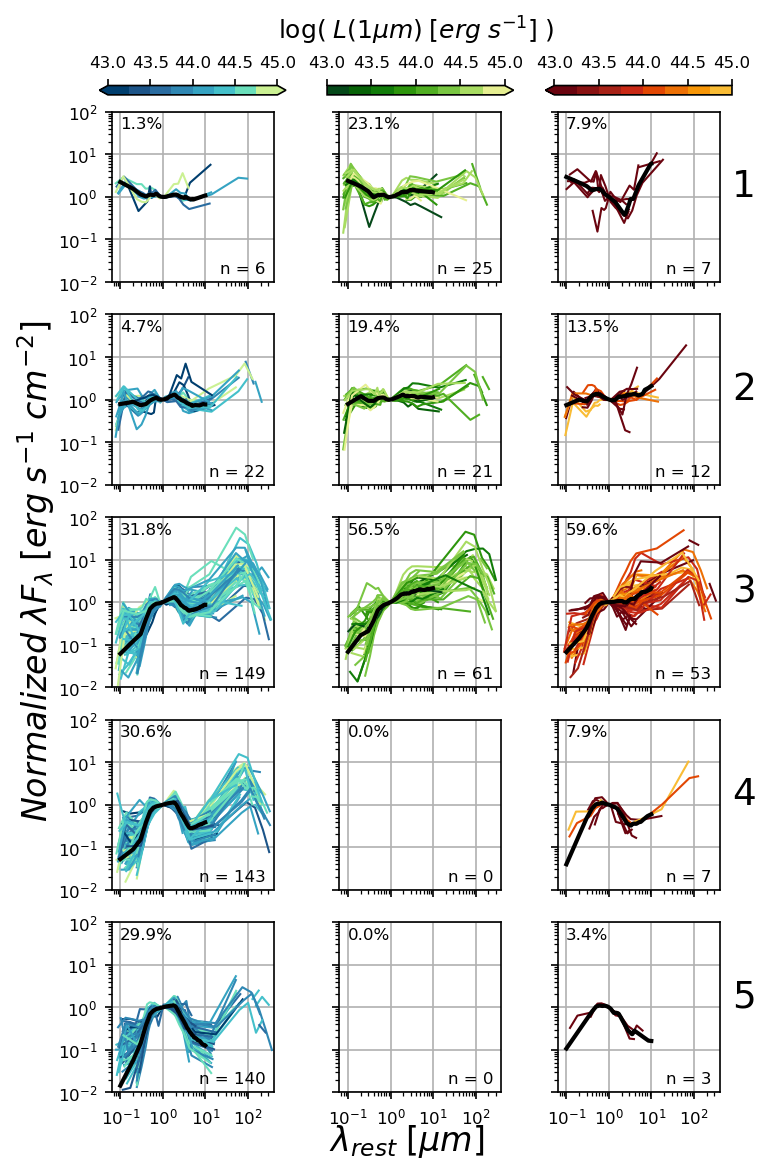

Number of AGN:	 {'RED': 89, 'GRN': 108, 'BLU': 468}
Number of AGN plotted:	 {'RED': 82, 'GRN': 107, 'BLU': 460}
RED missed:  7 (7.9%)
GRN missed:  1 (0.9%)
BLU missed:  8 (1.7%)


In [33]:
# add percents for my own use
PlotMosaic(
    panelData,
    cbarRange=(43,45),
    showPercent=True
)

# Explore Missed SEDs

In [23]:
def PlotSED_Row(
        x,                  # x-axis data LIST:   lam [A]
        y,                  # y-axis data LIST:  lamFlam [erg/s/cm2]
        z,                  # colorbar data LIST
        cmapKey,            # colormap options: red, grn, blu, (jet otherwise)
        n_ticks=9,          # number of ticks on colorbar
        showBar=True,       # show the colorbar 
        save='',            # filename to save
        median=True,        # plots a median line when true
        xmin=10**-2,        # plot range 
        xmax=10**3,         #   "    "
        ymin=10**-2,      #   "    "
        ymax=10**2,       #   "    "
        orientWide=False,   # true for tall, false for wide 
        cbarLabel='$Normalized \; \lambda F_{\lambda} \; at \; 24 \mu m$',
        cbarRange=None,      # tuple range of colorbar (min, max)
        title=None
):
    # check that lists are all same length 
    n = len(x)
    if(n!=len(y) and n!=len(z) and n!=len(cmapKey) ):
        print('[!] Bad inputs')
        return

    # determine subplot shape and parameters
    if(orientWide) :
        nrow = 1
        ncol = len(x)
        figsize = (4+(2*n), 4)
        cbarLocation = 'top'
    else:
        nrow = len(x)
        ncol = 1
        figsize = (6, 2+(2*n))
        cbarLocation = 'right'

    # build figure
    adp.SetStyle() 
    fig = plt.figure(figsize=figsize)    
    ax = []
    for i in range(n):
        ax.append(fig.add_subplot(nrow,ncol,i+1))
   
    # plot each SED
    for i in range(n): 
        # initialize plot settings 
        xTicks=True
        yTicks=True
        xLabel=False
        yLabel=False
        cbarLab=None
        # for wide plot 
        if(orientWide==1) : 
            if(i>0) :           
                yTicks = False
            if(i==int(n/2)):    
                xLabel = True 
                cbarLab = cbarLabel
            if(i==0) :          
                yLabel = True 
        # for tall plot 
        elif(orientWide==0) :
            if(i<n-1):          
                xTicks = False
            if(i==n-1):         
                xLabel = True 
            if(i==int(n/2)):    
                yLabel = True 
                cbarLab = cbarLabel

        # fix type
        if(isinstance(z[i], np.float64)) :
            zi = np.array([z[i]])
        else : 
            zi = z[i]
        # determine color range
        if(cbarRange):
            cbarMin=cbarRange[0]
            cbarMax=cbarRange[1]
            z_forMap = SED.PrepareCmapValues(zi,min=10**cbarMin,max=10**cbarMax)
        else : 
            z_forMap = SED.PrepareCmapValues(zi) 
            cbarMin=min(z_forMap[0])
            cbarMax=max(z_forMap[0])

        # get colormap 
        cmap_use = SED.GetCmap(cmapKey[i], n_ticks)

        # plot on axis 
        SED.PlotSED_ax(
            ax=ax[i],            
            x=x[i],             
            y=y[i],             
            z=z_forMap[1],             
            cmap=cmap_use,          
            median=median,   
            xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
            xTicks=xTicks,
            yTicks=yTicks,
            xLabel=xLabel,
            yLabel=yLabel
        )

        # colorbar 
        if(showBar) : 
            extend='neither'
            if(cbarRange) : 
                # check bounds
                smaller = np.nanmin(zi) < 10**cbarMin
                bigger = np.nanmax(zi) > 10**cbarMax
                if(smaller and bigger) :    extend = 'both'
                elif(smaller) :             extend = 'min'
                elif(bigger) :              extend = 'max'

            SED.PlotColorbar_ax(
                ax=ax[i], 
                cmap=cmap_use, 
                min=cbarMin, 
                max=cbarMax, 
                n_ticks=n_ticks, 
                label=cbarLab, 
                location=cbarLocation,
                extend=extend
            )

    # set title of plot 
    if(title) :
        plt.title(title)

    # save plot as image 
    if(save) : 
        adp.Save(save)
    
    # finish
    plt.show()
    plt.close()

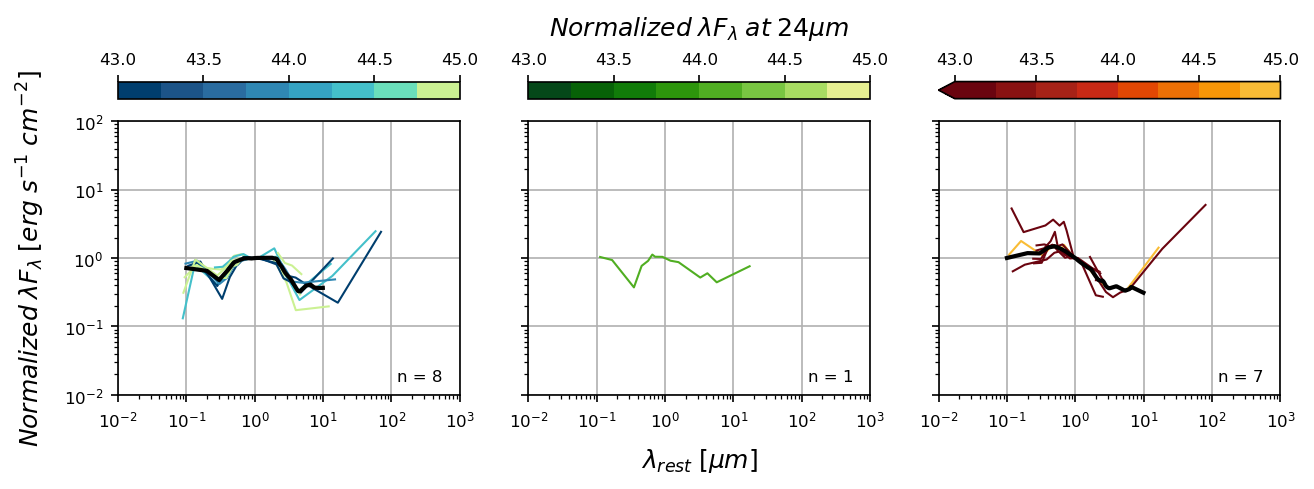

In [24]:
PlotSED_Row(
    x = [
        panelData['BLU']['xp'][5],
        panelData['GRN']['xp'][5],
        panelData['RED']['xp'][5]
    ],
    y = [
        panelData['BLU']['yp'][5],
        panelData['GRN']['yp'][5],
        panelData['RED']['yp'][5]
    ],
    z = [
        panelData['BLU']['zp'][5],
        panelData['GRN']['zp'][5],
        panelData['RED']['zp'][5]
    ],
    cmapKey = ['b','g','r'],
    cbarRange = (43,45),
    orientWide=True,
    n_ticks=5,
    save=adp.path_fig+'\\v2_SED_15panelMissed_z01.png'
)

In [35]:
# PlotMosaic(
#     panelData,
#     cbarRange=(43,45),
#     n_rows=6
# )
# # probably better to keep missed AGNs as separate plot (above)